<a href="https://colab.research.google.com/github/omkarsarde/Adversarial-Attack-on-Deep-Learning-Models/blob/main/GPU16G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Scaling 
# Device: GPU 
# Memory: 16 GB


In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fd59c819-2e16-8ccd-6052-c778ab3b6ac4)


In [2]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow import keras
import time
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

In [3]:

pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

In [4]:
# Split the dataset into train, test and validation sets
train_data = pcam['train']
test_data = pcam['test']
valid_data = pcam['validation']

In [5]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [6]:
train_data = train_data.map(convert_sample)
valid_data = valid_data.map(convert_sample)
test_data = test_data.map(convert_sample)

In [13]:
buffer_size = 1000
batch_size = 128
train_data_batch = train_data.batch(batch_size).shuffle(buffer_size).prefetch(2)
valid_data_batch = valid_data.batch(batch_size*2).prefetch(2)
test_data_batch = test_data.batch(batch_size*2).prefetch(2)

In [8]:
# STANDARD VGG16 Model
standard_Model = VGG16()
standard_Model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
standard_Model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# Vgg16 We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [7]:

class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)



In [12]:

time_callback = TimeHistory()
history = model.fit(train_data_batch, epochs = 5, callbacks=[ time_callback], validation_data = valid_data_batch, verbose=1)

Epoch 1/5
   6/2048 [..............................] - ETA: 5:23 - loss: 0.6931 - acc: 0.4714WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0476s vs `on_train_batch_end` time: 0.0925s). Check your callbacks.


2048/2048 [==============================] - 446s 169ms/step - loss: 0.4456 - acc: 0.7740 - val_loss: 0.3654 - val_acc: 0.8309
Epoch 2/5
2048/2048 [==============================] - 423s 166ms/step - loss: 0.2384 - acc: 0.9041 - val_loss: 0.4702 - val_acc: 0.8135
Epoch 3/5
2048/2048 [==============================] - 423s 167ms/step - loss: 0.1679 - acc: 0.9368 - val_loss: 0.3121 - val_acc: 0.8775
Epoch 4/5
2048/2048 [==============================] - 422s 166ms/step - loss: 0.1369 - acc: 0.9498 - val_loss: 0.3265 - val_acc: 0.8766
Epoch 5/5
2048/2048 [==============================] - 421s 166ms/step - loss: 0.1149 - acc: 0.9594 - val_loss: 0.4551 - val_acc: 0.8500


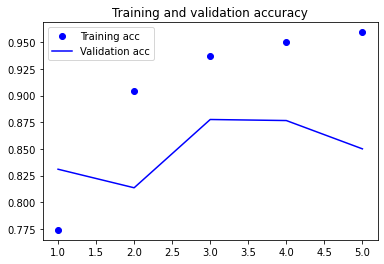

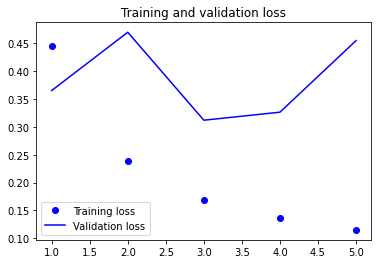

In [15]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
time_callback.times

[445.514878988266,
 422.81909799575806,
 423.06270599365234,
 421.5247004032135,
 421.3001251220703]

In [17]:
model.evaluate(test_data_batch, verbose=1)

128/128 [==============================] - 18s 132ms/step - loss: 0.7056 - acc: 0.7877


[0.7056131958961487, 0.787689208984375]

In [18]:
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_data_batch, verbose=0)[1]))

Test set accuracy is 0.7877


In [8]:
buffer_size = 1000
batch_size = 64
train_data_batch = train_data.batch(batch_size).shuffle(buffer_size).prefetch(2)
valid_data_batch = valid_data.batch(batch_size*2).prefetch(2)
test_data_batch = test_data.batch(batch_size*2).prefetch(2)

In [9]:
# Vgg16 We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [10]:
time_callback64 = TimeHistory()
history64 = model.fit(train_data_batch, epochs = 5, callbacks=[ time_callback64], validation_data = valid_data_batch, verbose=1)

Epoch 1/5
   6/4096 [..............................] - ETA: 5:53 - loss: 0.6933 - acc: 0.4948WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0285s vs `on_train_batch_end` time: 0.0485s). Check your callbacks.


4096/4096 [==============================] - 434s 91ms/step - loss: 0.3662 - acc: 0.8364 - val_loss: 0.3730 - val_acc: 0.8379
Epoch 2/5
4096/4096 [==============================] - 406s 89ms/step - loss: 0.1939 - acc: 0.9260 - val_loss: 0.3276 - val_acc: 0.8628
Epoch 3/5
4096/4096 [==============================] - 377s 89ms/step - loss: 0.1474 - acc: 0.9465 - val_loss: 0.3049 - val_acc: 0.8837
Epoch 4/5
4096/4096 [==============================] - 377s 89ms/step - loss: 0.1219 - acc: 0.9564 - val_loss: 0.3528 - val_acc: 0.8875
Epoch 5/5
4096/4096 [==============================] - 377s 89ms/step - loss: 0.1011 - acc: 0.9645 - val_loss: 0.4451 - val_acc: 0.8483


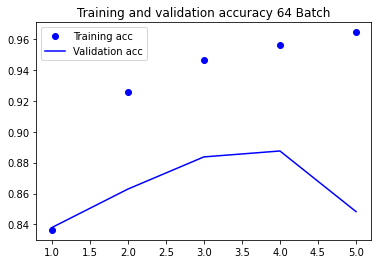

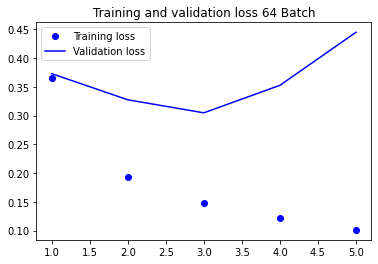

In [11]:

acc = history512.history['acc']
val_acc = history512.history['val_acc']
loss = history512.history['loss']
val_loss = history512.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 64 Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 64 Batch')
plt.legend()
plt.show()

In [19]:
time_callback512.times

[433.5644679069519,
 406.19016456604004,
 377.4921498298645,
 377.1333005428314,
 377.3741891384125]

In [21]:
# with tf.device('/device:GPU:0'):
model.evaluate(test_data_batch, verbose=1)

256/256 [==============================] - 12s 45ms/step - loss: 0.6323 - acc: 0.7930


[0.6322647929191589, 0.79296875]

In [22]:
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_data_batch, verbose=0)[1]))

Test set accuracy is 0.7930
